In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.utils import convert_kstar_evol_type
from cosmic.plotting import evolve_and_plot

import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Helper functions and variables for unit conversions

def aui_to_porb(aui, m_tot):
    # aui: a list of values, initial separation in AU
    # m_tot: a list of values, total mass in M_sun
    # result: a list of values, orbital period in given condition in days
    res = []
    for i in range(len(aui)):
        res.append((1/m_tot[i]**0.5) * (aui[i]**1.5) * 365)
    return res

# Used to convert separation in R_sun into AU
unit_factor = 1 / 215.032

# Helper function: given an array of data and an array of target,
# return an array of index that is nearest to the target value.
import math 
def findNearestList(data, targetList):
    res = []
    for num in targetList:
        res.append(findNearest(data, num))
    return res

def findNearest(data, target):
    n = len(data)
    res = -1
    minDiff = 10**5
    for i in range(n):
        if data[i] == 10**(-5):
            continue
        if abs(target - data[i]) <= minDiff:
            res = i
            minDiff = abs(target - data[i])
    return res

In [3]:
# Default BSEDict
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [4]:
NUM_DICT = 2000
NUM_SEP = 400

MASS_1 = 1.5
MASS_2 = 0.85
MASS_TOT = 2.35

ECC = 0

SEP_START = 0.5
SEP_END = 6

LAMBDA_START = -100
LAMBDA_END = 0

SOLAR_MET = 0.02

TPHYS_LIM = 6000

## Heatmap for $\alpha_{\mathrm{CE}} = 1.0$

In [5]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]

[-1.000e+02 -9.995e+01 -9.990e+01 ... -1.500e-01 -1.000e-01 -5.000e-02]


In [6]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [7]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [8]:
data1 = np.zeros((NUM_DICT,NUM_SEP)) # 2D-list to store results and ready to plot

for i in tqdm.tqdm(range(NUM_DICT)):
    # loop through the index of lambdaf
    bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDictList[i], nproc = 48)
    bpp['sep in AU'] = bpp['sep'] * unit_factor
    
    cond1 = (bpp['evol_type'] == 8) # Select evol type to be common envelope ends
    cond2 = (bpp['kstar_1'] <= 12) 
    cond3 = (bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (bpp['kstar_2'] <= 1)
    cond5 = (bpp['kstar_2'] >= 0) # Select kstar_2 to be MS

    specific_rows = bpp[(cond1) & (cond2) & (cond3) & (cond4) & (cond5)] # mask to select rows
    indexList = specific_rows.index.tolist() # list of index
    for j in range(NUM_SEP):
        # loop through the index of initial separations
        if j in indexList:
            data1[i][j] = specific_rows.loc[j, 'sep in AU']
        else:
            data1[i][j] = 10**(-5)

  0%|                                        | 6/2000 [00:17<1:34:23,  2.84s/it]


KeyboardInterrupt: 

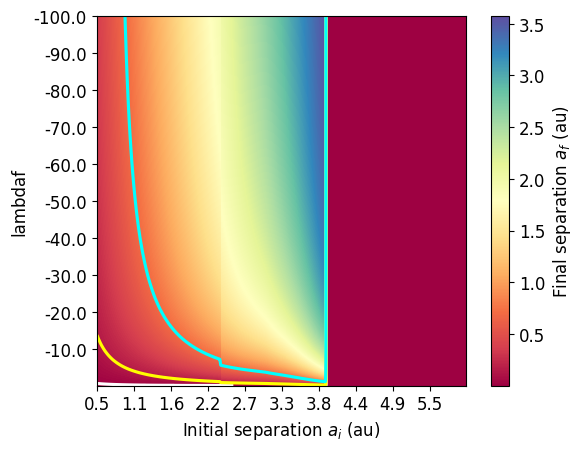

In [38]:
plt.imshow(data1, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data1.shape[1], 40)
y_tick_locations = np.arange(0, data1.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label

plt.contour(data1, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 1.png', dpi=300)
plt.show()

## Heatmap for $\alpha_{\mathrm{CE}} = 0.9$

In [ ]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]
    BSEDictList[i]['alpha1'] = 0.9

In [ ]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [ ]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [ ]:
data2 = np.zeros((NUM_DICT,NUM_SEP)) # 2D-list to store results and ready to plot

for i in tqdm.tqdm(range(NUM_DICT)):
    # loop through the index of lambdaf
    bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDictList[i], nproc = 48)
    bpp['sep in AU'] = bpp['sep'] * unit_factor
    
    cond1 = (bpp['evol_type'] == 8) # Select evol type to be common envelope ends
    cond2 = (bpp['kstar_1'] <= 12) 
    cond3 = (bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (bpp['kstar_2'] <= 1)
    cond5 = (bpp['kstar_2'] >= 0) # Select kstar_2 to be MS

    specific_rows = bpp[(cond1) & (cond2) & (cond3) & (cond4) & (cond5)] # mask to select rows
    indexList = specific_rows.index.tolist() # list of index
    for j in range(NUM_SEP):
        # loop through the index of initial separations
        if j in indexList:
            data2[i][j] = specific_rows.loc[j, 'sep in AU']
        else:
            data2[i][j] = 10**(-5)

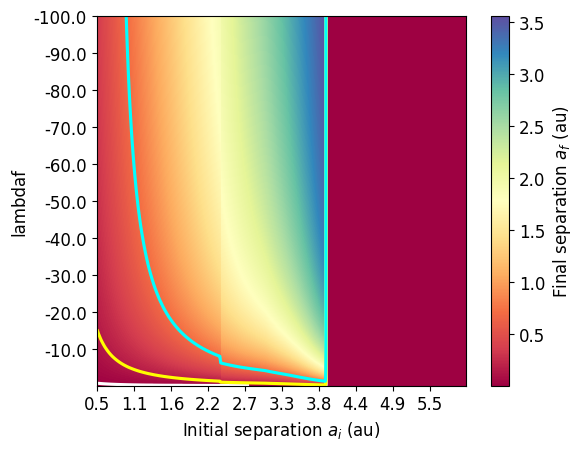

In [39]:
plt.imshow(data2, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data2.shape[1], 40)
y_tick_locations = np.arange(0, data2.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data2, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.9.png', dpi=300)
plt.show()

## Heatmap for $\alpha_{\mathrm{CE}} = 0.6$

In [ ]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]
    BSEDictList[i]['alpha1'] = 0.6

In [ ]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [ ]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [ ]:
data3 = np.zeros((NUM_DICT,NUM_SEP)) # 2D-list to store results and ready to plot

for i in tqdm.tqdm(range(NUM_DICT)):
    # loop through the index of lambdaf
    bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDictList[i], nproc = 48)
    bpp['sep in AU'] = bpp['sep'] * unit_factor
    
    cond1 = (bpp['evol_type'] == 8) # Select evol type to be common envelope ends
    cond2 = (bpp['kstar_1'] <= 12) 
    cond3 = (bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (bpp['kstar_2'] <= 1)
    cond5 = (bpp['kstar_2'] >= 0) # Select kstar_2 to be MS

    specific_rows = bpp[(cond1) & (cond2) & (cond3) & (cond4) & (cond5)] # mask to select rows
    indexList = specific_rows.index.tolist() # list of index
    for j in range(NUM_SEP):
        # loop through the index of initial separations
        if j in indexList:
            data3[i][j] = specific_rows.loc[j, 'sep in AU']
        else:
            data3[i][j] = 10**(-5)

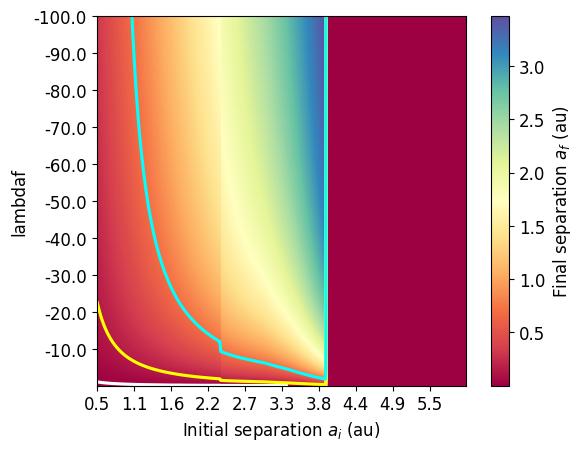

In [40]:
plt.imshow(data3, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data3.shape[1], 40)
y_tick_locations = np.arange(0, data3.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data3, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.6.png', dpi=300)
plt.show()

## Heatmap for $\alpha_{\mathrm{CE}} = 0.3$

In [ ]:
# Create a list of BSEDict for different lambdaf values
# lambdaf ranges from 0 to -10 with NUM_DICT values in between

lambdaList = np.linspace(LAMBDA_START, LAMBDA_END, NUM_DICT, endpoint=False)
print(lambdaList)

BSEDictList = [BSEDict.copy() for i in range(NUM_DICT)]
for i in range(NUM_DICT):
    BSEDictList[i]['lambdaf'] = lambdaList[i]
    BSEDictList[i]['alpha1'] = 0.3

In [ ]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [ ]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [ ]:
data4 = np.zeros((NUM_DICT,NUM_SEP)) # 2D-list to store results and ready to plot

for i in tqdm.tqdm(range(NUM_DICT)):
    # loop through the index of lambdaf
    bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDictList[i], nproc = 48)
    bpp['sep in AU'] = bpp['sep'] * unit_factor
    
    cond1 = (bpp['evol_type'] == 8) # Select evol type to be common envelope ends
    cond2 = (bpp['kstar_1'] <= 12) 
    cond3 = (bpp['kstar_1'] >= 10) # Select kstar_1 to be WD
    cond4 = (bpp['kstar_2'] <= 1)
    cond5 = (bpp['kstar_2'] >= 0) # Select kstar_2 to be MS

    specific_rows = bpp[(cond1) & (cond2) & (cond3) & (cond4) & (cond5)] # mask to select rows
    indexList = specific_rows.index.tolist() # list of index
    for j in range(NUM_SEP):
        # loop through the index of initial separations
        if j in indexList:
            data4[i][j] = specific_rows.loc[j, 'sep in AU']
        else:
            data4[i][j] = 10**(-5)

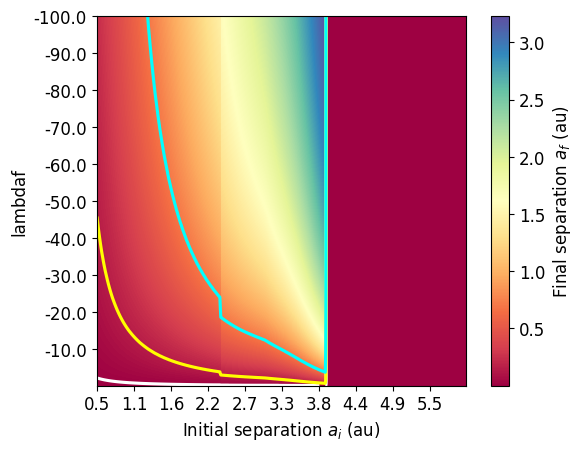

In [41]:
plt.imshow(data4, cmap='Spectral', aspect = 0.2)

cbar = plt.colorbar()  # Customize color bar label
cbar.ax.tick_params(labelsize=12)  # Adjust font size in color bar
cbar.ax.set_ylabel('Final separation $a_f$ (au)', fontsize=12)  # Add label to color bar
cbar.ax.figure.canvas.draw()

x_tick_locations = np.arange(0, data4.shape[1], 40)
y_tick_locations = np.arange(0, data4.shape[0], 200)
x_tick_labels = [f'{ai_list[i]:.1f}' for i in x_tick_locations]
y_tick_labels = [f'{lambdaList[i]:.1f}' for i in y_tick_locations]
plt.xticks(x_tick_locations, x_tick_labels, fontsize=12)
plt.yticks(y_tick_locations, y_tick_labels, fontsize=12)

plt.xlabel('Initial separation $a_i$ (au)', fontsize=12)  # Add X axis label
plt.ylabel('lambdaf', fontsize=12)  # Add Y axis label
plt.contour(data4, levels=[0.01, 0.15, 0.7], colors=['white', 'yellow', 'cyan'], linewidths = 2.25)
plt.savefig('1.5+0.8 Heatmap, alpha = 0.3.png', dpi=300)
plt.show()

In [ ]:
import csv

# # Specify the file name
# filename = '1.5+0.8 alpha=1 result.csv'

# # Open the file in write mode
# with open(filename, 'w', newline='') as file:
#     writer = csv.writer(file)
#     # Write each row to the CSV file
#     writer.writerows(data1)

# # Specify the file name
# filename = '1.5+0.8 alpha=0.9 result.csv'

# # Open the file in write mode
# with open(filename, 'w', newline='') as file:
#     writer = csv.writer(file)
#     # Write each row to the CSV file
#     writer.writerows(data2)

#     # Specify the file name

# filename = '1.5+0.8 alpha=0.6 result.csv'

# # Open the file in write mode
# with open(filename, 'w', newline='') as file:
#     writer = csv.writer(file)
#     # Write each row to the CSV file
#     writer.writerows(data3)

# Specify the file name
filename = '1.5+0.8 alpha=0.3 result.csv'

# Open the file in write mode
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write each row to the CSV file
    writer.writerows(data4)

## $\lambda_f$ fitting with Yamaguchi results

### Binding Energy of entire envelope

In [32]:
import numpy as np
csv_file_path = '1.5+0.8 alpha=1 result.csv'
data1 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.9 result.csv'
data2 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.6 result.csv'
data3 = np.genfromtxt(csv_file_path, delimiter=',')

csv_file_path = '1.5+0.8 alpha=0.3 result.csv'
data4 = np.genfromtxt(csv_file_path, delimiter=',')

(0.001, 10)

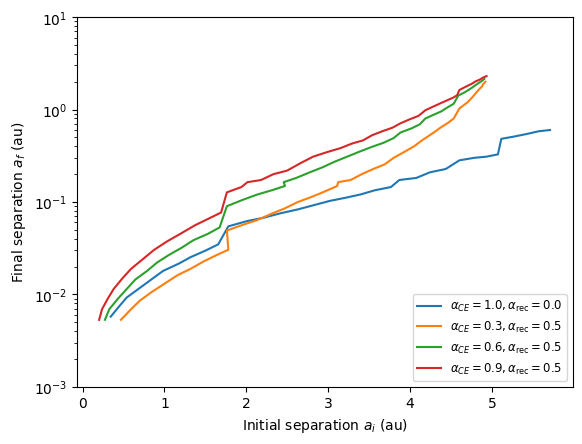

In [10]:
# Results in Yamaguchi 2024
x1_1 = [0.34397163120567376, 0.45035460992907794, 0.5390070921985815, 0.6808510638297872, 0.8226950354609929, 0.9822695035460993, 1.177304964539007, 1.3191489361702127, 1.49645390070922, 1.6560283687943262, 1.7801418439716312, 2.0106382978723403, 2.2056737588652484, 2.400709219858156, 2.631205673758865, 2.826241134751773, 3.021276595744681, 3.2163120567375887, 3.393617021276596, 3.570921985815603, 3.765957446808511]
y1_1 = [0.005736152510448681, 0.0074741742463175255, 0.009236708571873866, 0.011414877741680032, 0.014106695349712456, 0.01790084628235538, 0.021544346900318832, 0.025252178500722026, 0.029598136438421834, 0.03469204372218366, 0.054404169360832845, 0.06210169418915616, 0.06723357536499334, 0.07474174246317529, 0.08308836821639956, 0.09236708571873861, 0.10268198434168875, 0.11116728815539267, 0.1203537897621902, 0.13379404427086947, 0.14485034710121478]

x2_1 = [0.46808510638297873, 0.5921985815602837, 0.6985815602836879, 0.8404255319148937, 1, 1.1595744680851063, 1.3191489361702127, 1.4787234042553192, 1.6382978723404256, 1.7801418439716312, 1.7624113475177305, 1.9397163120567376, 2.1347517730496453, 2.3120567375886525, 2.4716312056737593, 2.631205673758865, 2.773049645390071, 2.9326241134751774, 3.1099290780141846]
y2_1 = [0.005298316906283708, 0.006903676932863998, 0.008531678524172805, 0.010543589908346808, 0.013029943385750224, 0.01610262027560939, 0.018873918221350976, 0.02271547585601245, 0.0266248614403985, 0.03039195382313198, 0.04893900918477494, 0.055863280664316214, 0.06376725190323276, 0.07474174246317529, 0.08531678524172806, 0.1, 0.11116728815539267, 0.12689610031679222, 0.1487352107293511]

x3_1 = [0.2730496453900708, 0.32624113475177297, 0.43262411347517726, 0.5390070921985815, 0.6453900709219857, 0.7872340425531914, 0.9113475177304965, 1.053191489361702, 1.2127659574468086, 1.3546099290780143, 1.5319148936170213, 1.6737588652482271, 1.7624113475177305, 1.9574468085106385, 2.1347517730496453, 2.3120567375886525, 2.4716312056737593]
y3_1 = [0.005298316906283708, 0.006903676932863998, 0.008995451958872764, 0.011414877741680032, 0.01448503471012148, 0.01790084628235538, 0.022122162910704492, 0.0266248614403985, 0.03204402976245166, 0.03856620421163472, 0.04520353656360243, 0.05298316906283707, 0.08995451958872763, 0.1054358990834681, 0.1203537897621902, 0.13379404427086947, 0.1487352107293511]

x4_1 = [0.202127659574468, 0.23758865248226946, 0.3085106382978723, 0.3794326241134751, 0.4858156028368794, 0.5921985815602837, 0.7340425531914894, 0.875886524822695, 1.0354609929078014, 1.1950354609929077, 1.372340425531915, 1.5319148936170213, 1.6914893617021276, 1.7624113475177305, 1.9397163120567376]
y4_1 = [0.005298316906283708, 0.006903676932863998, 0.008995451958872764, 0.011414877741680032, 0.014873521072935119, 0.018873918221350976, 0.02395026619987486, 0.03039195382313198, 0.0375588809068008, 0.04520353656360243, 0.055863280664316214, 0.06547747961440266, 0.07674630429274296, 0.12689610031679222, 0.14485034710121478]

x1_2 = [3.868512110726644, 4.076124567474048, 4.242214532871973, 4.43598615916955, 4.602076124567474, 4.782006920415225, 4.934256055363322, 5.072664359861592, 5.114186851211073, 5.26643598615917, 5.432525951557094, 5.570934256055363, 5.709342560553633]
y1_2 = [0.17272727272727273, 0.18181818181818182, 0.2090909090909091, 0.2272727272727273, 0.28181818181818186, 0.30000000000000004, 0.3090909090909091, 0.32727272727272727, 0.4818181818181818, 0.509090909090909, 0.5454545454545454, 0.5818181818181818, 0.6]

x2_2 = [3.1211072664359865, 3.273356401384083, 3.4117647058823533, 3.5501730103806226, 3.688581314878893, 3.7993079584775087, 3.9238754325259517, 4.048442906574394, 4.145328719723183, 4.2145328719723185, 4.311418685121107, 4.380622837370242, 4.463667820069205, 4.53287197231834, 4.602076124567474, 4.657439446366782, 4.698961937716263, 4.740484429065744, 4.768166089965398, 4.795847750865052, 4.8235294117647065, 4.85121107266436, 4.8788927335640135, 4.892733564013841, 4.920415224913494]
y2_2 = [0.16363636363636364, 0.17272727272727273, 0.2, 0.2272727272727273, 0.2545454545454545, 0.30000000000000004, 0.34545454545454546, 0.4, 0.4636363636363636, 0.509090909090909, 0.5818181818181818, 0.6454545454545455, 0.7181818181818181, 0.8, 1.0272727272727273, 1.1181818181818182, 1.190909090909091, 1.2999999999999998, 1.3818181818181818, 1.481818181818182, 1.5818181818181818, 1.6818181818181817, 1.7818181818181817, 1.8818181818181818, 2]

x3_2 = [2.4567474048442905, 2.6089965397923875, 2.7750865051903113, 2.9273356401384083, 3.0795847750865053, 3.2318339100346023, 3.397923875432526, 3.522491349480969, 3.6747404844290656, 3.7993079584775087, 3.8823529411764706, 4.02076124567474, 4.117647058823529, 4.186851211072664, 4.269896193771626, 4.380622837370242, 4.449826989619377, 4.53287197231834, 4.588235294117647, 4.657439446366782, 4.712802768166091, 4.754325259515571, 4.795847750865052, 4.837370242214533, 4.8788927335640135, 4.906574394463668]
y3_2 = [0.16363636363636364, 0.18181818181818182, 0.2090909090909091, 0.2363636363636364, 0.2727272727272727, 0.3090909090909091, 0.35454545454545455, 0.39090909090909093, 0.4363636363636364, 0.4909090909090909, 0.5636363636363636, 0.6272727272727272, 0.6909090909090909, 0.8, 0.8636363636363636, 0.9545454545454546, 1.0454545454545454, 1.1545454545454545, 1.418181818181818, 1.518181818181818, 1.6272727272727272, 1.718181818181818, 1.8272727272727272, 1.9363636363636363, 2.0454545454545454, 2.1454545454545455]

x4_2 = [2.013840830449827, 2.179930795847751, 2.3321799307958475, 2.4982698961937717, 2.6643598615916955, 2.8166089965397925, 2.982698961937716, 3.14878892733564, 3.28719723183391, 3.42560553633218, 3.536332179930796, 3.660899653979239, 3.7854671280276815, 3.8823529411764706, 3.993079584775087, 4.103806228373703, 4.186851211072664, 4.269896193771626, 4.366782006920415, 4.449826989619377, 4.53287197231834, 4.57439446366782, 4.602076124567474, 4.6435986159169556, 4.698961937716263, 4.754325259515571, 4.795847750865052, 4.85121107266436, 4.892733564013841, 4.934256055363322]
y4_2 = [0.16363636363636364, 0.17272727272727273, 0.2, 0.2181818181818182, 0.26363636363636367, 0.3090909090909091, 0.34545454545454546, 0.38181818181818183, 0.42727272727272725, 0.4636363636363636, 0.5272727272727272, 0.5818181818181818, 0.6363636363636364, 0.7090909090909091, 0.7818181818181817, 0.8545454545454545, 0.9818181818181818, 1.0636363636363635, 1.1636363636363636, 1.2545454545454544, 1.3545454545454545, 1.4272727272727272, 1.6272727272727272, 1.7, 1.8, 1.9, 2.009090909090909, 2.109090909090909, 2.218181818181818, 2.3]

x = [0, 0, 0, 0]
y = [0, 0, 0, 0]
x[0] = x1_1 + x1_2
x[1] = x2_1 + x2_2
x[2] = x3_1 + x3_2
x[3] = x4_1 + x4_2

y[0] = y1_1 + y1_2
y[1] = y2_1 + y2_2
y[2] = y3_1 + y3_2
y[3] = y4_1 + y4_2

plt.plot(x[0], y[0], label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
plt.plot(x[1], y[1], label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
plt.plot(x[2], y[2], label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
plt.plot(x[3], y[3], label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel('Final separation $a_f$ (au)')
plt.legend(loc='lower right', fontsize='small')  # Add a legend to differentiate between lines

# Change y-axis to logarithmic scale
plt.yscale('log')
plt.ylim(10**(-3), 10)

i = 0
[-0.5, -0.5, -0.5499999999999972, -0.5, -0.44999999999998863, -0.44999999999998863, -0.3999999999999915, -0.44999999999998863, -0.3999999999999915, -0.3999999999999915, -0.5999999999999943, -0.5499999999999972, -0.5499999999999972, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3499999999999943, -0.29999999999999716, -0.25, -0.25]
i = 1
[-1.6999999999999886, -1.3499999999999943, -1.1499999999999915, -1.0999999999999943, -1.0499999999999972, -1.0499999999999972, -1.0499999999999972, -1.0499999999999972, -1.0999999999999943, -1.0999999999999943, -1.7999999999999972, -1.7999999999999972, -1.75, -1.8499999999999943, -1.5, -1.6499999999999915, -1.75, -1.8499999999999943, -1.9499999999999886, -2.0999999999999943, -1.9499999999999886, -2.0, -1.8999999999999915, -1.6999999999999886, -1.6999999999999886]
i = 2
[-0.8499999999999943, -0.8499999999999943, -0.9499999999999886, -1.0999999999999943, -1.0999999999999943, -1.04999999999

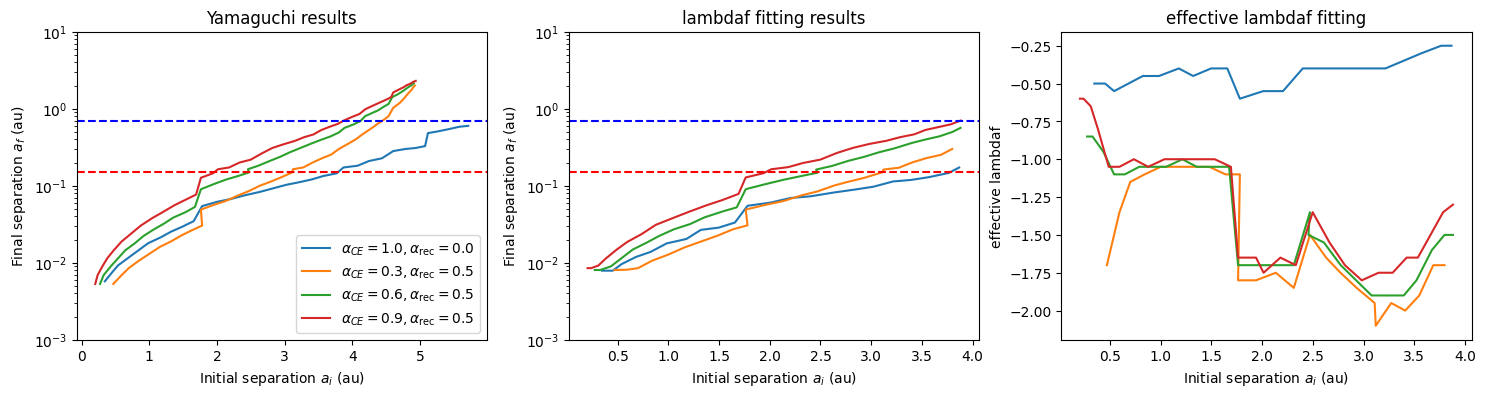

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    fitting_x_list = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        if lambdaIndex != -1:
            res.append(data[i][lambdaIndex][indexList[j]])
            lambdaFitting.append(lambdaList[lambdaIndex])
            fitting_x_list.append(x_list[j])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].axhline(y=0.7, color='blue', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 10)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].axhline(y=0.7, color='blue', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 10)

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].set_title('effective lambdaf fitting')

# Display the plot
plt.savefig('1.5+0.8 fitting lambdaf whole.png', dpi=300)
plt.show()

### Binding energy of just the outer envelope

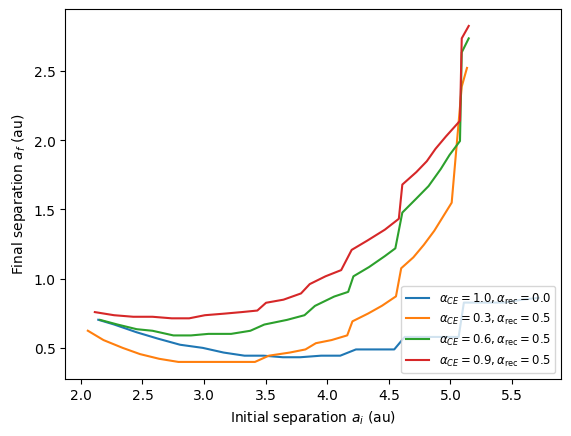

In [12]:
X = [0,0,0,0]
Y = [0,0,0,0]

X[0] = [2.1413427561837457, 2.2685512367491167, 2.452296819787986, 2.6219081272084805, 2.8056537102473498, 2.989399293286219, 3.159010600706714, 3.328621908127208, 3.4840989399293285, 3.639575971731449, 3.7809187279151946, 3.9505300353356887, 4.106007067137809, 4.23321554770318, 4.402826855123674, 4.544169611307421, 4.628975265017668, 4.784452296819788, 4.954063604240282, 5.06713780918728, 5.109540636042403, 5.293286219081272, 5.434628975265017, 5.590106007067138, 5.717314487632509]
Y[0] = [0.7030075187969924, 0.6691729323308271, 0.612781954887218, 0.5676691729323309, 0.5225563909774436, 0.5, 0.46616541353383456, 0.443609022556391, 0.443609022556391, 0.4323308270676692, 0.4323308270676692, 0.443609022556391, 0.443609022556391, 0.4887218045112782, 0.4887218045112782, 0.4887218045112782, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.5789473684210527, 0.8270676691729323, 0.8270676691729323, 0.8270676691729323, 0.849624060150376, 0.8609022556390977]

X[1] = [2.056537102473498, 2.1837455830388692, 2.339222614840989, 2.480565371024735, 2.636042402826855, 2.791519434628975, 2.9611307420494697, 3.11660777385159, 3.2579505300353357, 3.413427561837456, 3.5265017667844525, 3.696113074204947, 3.823321554770318, 3.9081272084805656, 4.035335689045937, 4.162544169611307, 4.204946996466431, 4.332155477031803, 4.445229681978798, 4.5583038869257955, 4.6007067137809186, 4.69964664310954, 4.784452296819788, 4.869257950530035, 4.939929328621908, 5.010600706713781, 5.092198581560284, 5.134751773049645]
Y[1] = [0.6240601503759399, 0.556390977443609, 0.5, 0.4548872180451128, 0.42105263157894735, 0.3984962406015038, 0.3984962406015038, 0.3984962406015038, 0.3984962406015038, 0.3984962406015038, 0.443609022556391, 0.46616541353383456, 0.4887218045112782, 0.5338345864661654, 0.556390977443609, 0.5902255639097744, 0.6917293233082706, 0.7481203007518797, 0.8045112781954887, 0.8721804511278195, 1.0751879699248121, 1.1541353383458646, 1.244360902255639, 1.3458646616541352, 1.4473684210526314, 1.5488721804511278, 2.3876404494382024, 2.5224719101123596]

X[2] = [2.1560283687943262, 2.297872340425532, 2.453900709219858, 2.581560283687943, 2.75177304964539, 2.8936170212765955, 3.0354609929078014, 3.219858156028369, 3.375886524822695, 3.4893617021276597, 3.673758865248227, 3.8156028368794326, 3.9007092198581557, 4.056737588652482, 4.170212765957446, 4.212765957446809, 4.340425531914894, 4.468085106382979, 4.553191489361702, 4.609929078014185, 4.723404255319149, 4.822695035460993, 4.921985815602836, 4.99290780141844, 5.078014184397163, 5.092198581560284, 5.148936170212766]
Y[2] = [0.702247191011236, 0.6685393258426966, 0.6348314606741574, 0.6235955056179776, 0.5898876404494382, 0.5898876404494382, 0.601123595505618, 0.601123595505618, 0.6235955056179776, 0.6685393258426966, 0.702247191011236, 0.7359550561797754, 0.803370786516854, 0.8707865168539326, 0.904494382022472, 1.0168539325842696, 1.0842696629213484, 1.1629213483146068, 1.2191011235955056, 1.4775280898876404, 1.5786516853932584, 1.6685393258426966, 1.7921348314606742, 1.8932584269662922, 1.99438202247191, 2.634831460674157, 2.735955056179775]

X[3] = [2.1134751773049647, 2.269503546099291, 2.425531914893617, 2.581560283687943, 2.7375886524822697, 2.879432624113475, 3.00709219858156, 3.1631205673758864, 3.3049645390070923, 3.4326241134751774, 3.50354609929078, 3.6453900709219855, 3.7872340425531914, 3.8581560283687946, 3.9858156028368796, 4.113475177304965, 4.198581560283688, 4.326241134751773, 4.468085106382979, 4.581560283687943, 4.609929078014185, 4.723404255319149, 4.808510638297872, 4.879432624113475, 4.964539007092199, 5.078014184397163, 5.092198581560284, 5.148936170212766]
Y[3] = [0.7584269662921348, 0.7359550561797754, 0.7247191011235956, 0.7247191011235956, 0.7134831460674158, 0.7134831460674158, 0.7359550561797754, 0.7471910112359552, 0.7584269662921348, 0.7696629213483146, 0.8258426966292136, 0.848314606741573, 0.8932584269662922, 0.9606741573033708, 1.0168539325842696, 1.0617977528089888, 1.2078651685393258, 1.2752808988764046, 1.353932584269663, 1.4325842696629214, 1.6797752808988764, 1.7696629213483146, 1.848314606741573, 1.9382022471910112, 2.0280898876404496, 2.140449438202247, 2.735955056179775, 2.8258426966292136]

plt.plot(X[0], Y[0], label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
plt.plot(X[1], Y[1], label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
plt.plot(X[2], Y[2], label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
plt.plot(X[3], Y[3], label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

plt.xlabel('Initial separation $a_i$ (au)')
plt.ylabel('Final separation $a_f$ (au)')
plt.legend(loc='lower right', fontsize='small')  # Add a legend to differentiate between lines

i = 0
[-8.649999999999991, -7.1499999999999915, -4.299999999999997, -3.5, -2.8499999999999943, -2.4499999999999886, -1.9499999999999886, -1.5499999999999972, -1.2999999999999972, -1.0, -0.7999999999999972]
i = 1
[-26.099999999999994, -19.75, -15.149999999999991, -9.549999999999997, -7.949999999999989, -6.8999999999999915, -6.349999999999994, -5.6499999999999915, -5.0, -4.199999999999989, -4.0, -3.299999999999997, -2.799999999999997, -2.6499999999999915]
i = 2
[-14.149999999999991, -11.599999999999994, -7.5, -6.75, -5.699999999999989, -5.25, -4.949999999999989, -4.199999999999989, -3.6999999999999886, -3.5, -2.799999999999997, -2.299999999999997, -2.1999999999999886]
i = 3
[-11.099999999999994, -9.149999999999991, -6.1499999999999915, -5.5, -4.949999999999989, -4.5, -4.3999999999999915, -3.8999999999999915, -3.5, -3.0, -3.0, -2.5, -2.0999999999999943, -2.0]


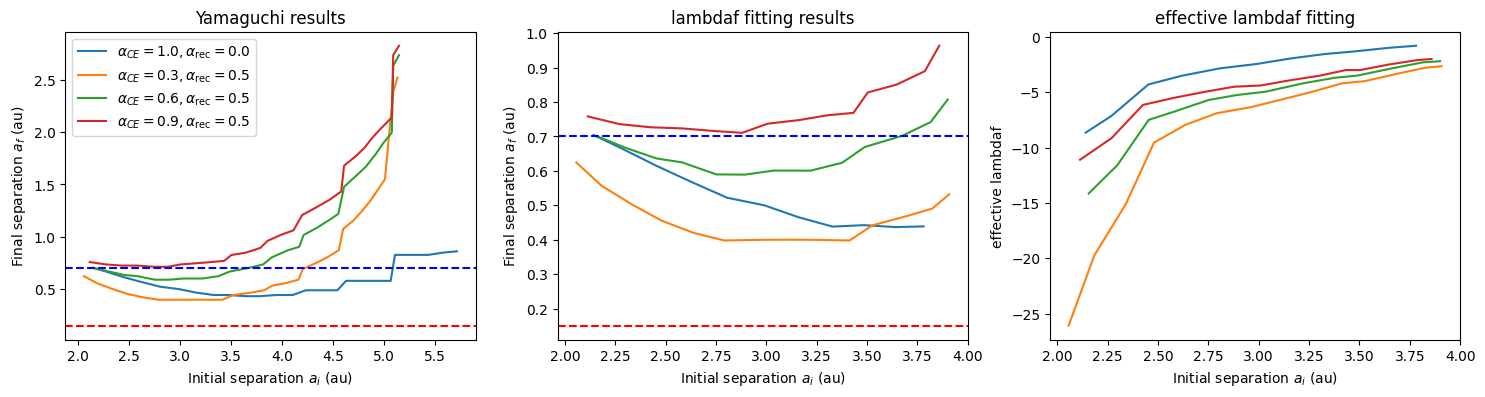

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(X)):
    x_list = X[i]
    y_list = Y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

for i in range(len(X)):
    x_list = X[i]
    y_list = Y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    fitting_x_list = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        if lambdaIndex != -1:
            res.append(data[i][lambdaIndex][indexList[j]])
            lambdaFitting.append(lambdaList[lambdaIndex])
            fitting_x_list.append(x_list[j])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='upper left')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].axhline(y=0.7, color='blue', linestyle='--')

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].axhline(y=0.7, color='blue', linestyle='--')

axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].set_title('effective lambdaf fitting')

# Display the plot
plt.savefig('1.5+0.8 fitting lambdaf part.png', dpi=300)
plt.show()

## Default $\lambda_{\mathrm{CE}}$

In [14]:
# Default BSEDict
BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 
           'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 
           'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 
           'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 
           'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 
           'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 
           'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
           'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 
           'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 
           'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 
           'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 
           'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 
           'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

In [16]:
# List of initial conditions for simulation later

m1_list = [MASS_1 for i in range(NUM_SEP)]
m2_list = [MASS_2 for i in range(NUM_SEP)]
mtot_list = [MASS_TOT for i in range(NUM_SEP)]
ai_list = np.linspace(SEP_START, SEP_END, NUM_SEP)
porb_i_list = aui_to_porb(ai_list, mtot_list)

ecc_list = [ECC for i in range(NUM_SEP)]
tphysf_list = [TPHYS_LIM for i in range(NUM_SEP)]
kstar1_list = [1 for i in range(NUM_SEP)]
kstar2_list = [1 for i in range(NUM_SEP)]
metallicity_list = [SOLAR_MET for i in range(NUM_SEP)] # solar metallicity

In [17]:
binary_set = InitialBinaryTable.InitialBinaries(m1=m1_list, m2=m2_list, 
                                                porb=porb_i_list, ecc=ecc_list, 
                                                tphysf=tphysf_list, kstar1=kstar1_list, kstar2=kstar2_list, 
                                                metallicity=metallicity_list)

In [18]:
def lambda_CE(bpp_row, m1):
    mass = bpp_row['mass_1']
    lum = bpp_row['lum_1']
    star = bpp_row['kstar_1']
    menv = bpp_row['menv_1']
    rad = bpp_row['rad_1']
    rad_zams = mass if m1 <= 1 else mass ** 0.6

    if menv >= 1:
        if star == 2 or star == 3: 
            # If the star is HG or GB
            lambda_1 = min(0.80, (3 / (2.4 + mass ** (-3/2))) - 0.15 * math.log(lum, 10))
        elif star == 4 or star == 5 or star == 6:
            # If the star is CHeB, E-AGB, or TP-AGB
            lambda_3 = min(0.9, 0.58 + 0.75 * math.log(mass, 10)) - 0.08 * math.log(lum, 10)
            if star == 4 or star == 5:
                # If the star is CHeB or E-AGB
                lambda_1 = min(0.8, 1.25 - 0.15 * math.log(lum, 10), lambda_3)
            else:
                # If the star is TP-AGB
                lambda_1 = max(-3.5 - 0.75 * math.log(mass, 10) + math.log(lum, 10), lambda_3)
        else:
            # Should not reach here
            lambda_1 = 0
        return 2 * lambda_1
        
    elif 0 < menv < 1:
        lambda_2 = 0.42 * (rad_zams / rad) ** 0.4
        lambda_1 = min(0.80, (3 / (2.4 + mass ** (-3/2))) - 0.15 * math.log(lum, 10))
        return 2 * (lambda_2 + menv**0.5 * (lambda_1 - lambda_2))
    
    else:
        lambda_2 = 0.42 * (rad_zams / rad) ** 0.4
        return lambda_2

In [19]:
default_data = np.zeros(NUM_SEP)

bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=binary_set, BSEDict=BSEDict)
bpp['sep in AU'] = bpp['sep'] * unit_factor

for i in tqdm.tqdm(range(NUM_SEP)):
    single_bpp = bpp.loc[i].copy()
    cond1 = (single_bpp['evol_type']==7)
    # cond2 = (single_bpp['evol_type']==8)
    
    if (len(single_bpp[(cond1)]) != 0):
        specific_row1 = single_bpp[(cond1)].iloc[0]

        default_data[i] = lambda_CE(specific_row1, MASS_1)

print(default_data.tolist())

100%|███████████████████████████████████████| 400/400 [00:00<00:00, 1106.13it/s]

[1.2962148989970181, 1.290831314445425, 1.2853179631707594, 1.280258399527585, 1.2750405996853758, 1.26995837071571, 1.2653240523251243, 1.2604931564702495, 1.2557785971905548, 1.2511722776133563, 1.2470134301296767, 1.2426165878960225, 1.238313779896896, 1.234101124742742, 1.2299748308928138, 1.2259311875150996, 1.2219665552776213, 1.218077357401126, 1.2145090512905357, 1.2108056992551681, 1.2072335020341223, 1.203621656313533, 1.2000745724817834, 1.1965842746921465, 1.1931528924646082, 1.1897740213342456, 1.1864508911505478, 1.183176513533827, 1.179951370549682, 1.176774956022173, 1.1736430184123603, 1.1705543249075212, 1.1675079534026962, 1.164504345983889, 1.161539884816046, 1.1586133958219742, 1.1560007159965737, 1.1531903388865548, 1.1504171778117063, 1.1476802904177699, 1.1450096599914854, 1.1422911139384277, 1.1396023797692916, 1.1369443812129854, 1.134315058372477, 1.131712631039735, 1.1291359589245649, 1.1265838988719965, 1.1243146952730574, 1.1218931043724356, 1.119500079030

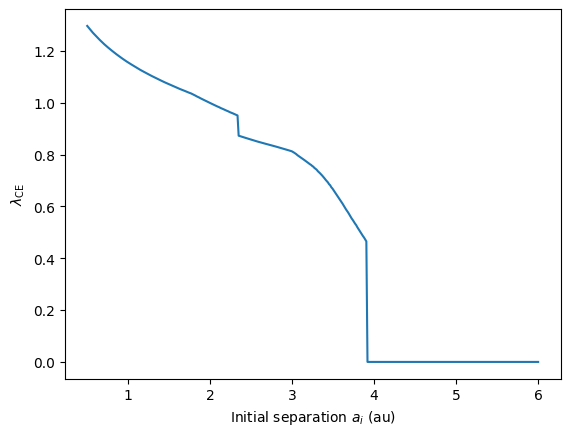

In [20]:
# Create the plot
plt.plot(ai_list, default_data)

# Add titles and labels
plt.xlabel(r'Initial separation $a_i$ (au)')
plt.ylabel(r'$\lambda_{\mathrm{CE}}$')

# Show the plot
plt.show()

for i in range(len(default_data)):
    default_data[i] *= -1

i = 0
[-0.5, -0.5, -0.5499999999999972, -0.5, -0.44999999999998863, -0.44999999999998863, -0.3999999999999915, -0.44999999999998863, -0.3999999999999915, -0.3999999999999915, -0.5999999999999943, -0.5499999999999972, -0.5499999999999972, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3999999999999915, -0.3499999999999943, -0.29999999999999716, -0.25, -0.25]
i = 1
[-1.6999999999999886, -1.3499999999999943, -1.1499999999999915, -1.0999999999999943, -1.0499999999999972, -1.0499999999999972, -1.0499999999999972, -1.0499999999999972, -1.0999999999999943, -1.0999999999999943, -1.7999999999999972, -1.7999999999999972, -1.75, -1.8499999999999943, -1.5, -1.6499999999999915, -1.75, -1.8499999999999943, -1.9499999999999886, -2.0999999999999943, -1.9499999999999886, -2.0, -1.8999999999999915, -1.6999999999999886, -1.6999999999999886]
i = 2
[-0.8499999999999943, -0.8499999999999943, -0.9499999999999886, -1.0999999999999943, -1.0999999999999943, -1.04999999999

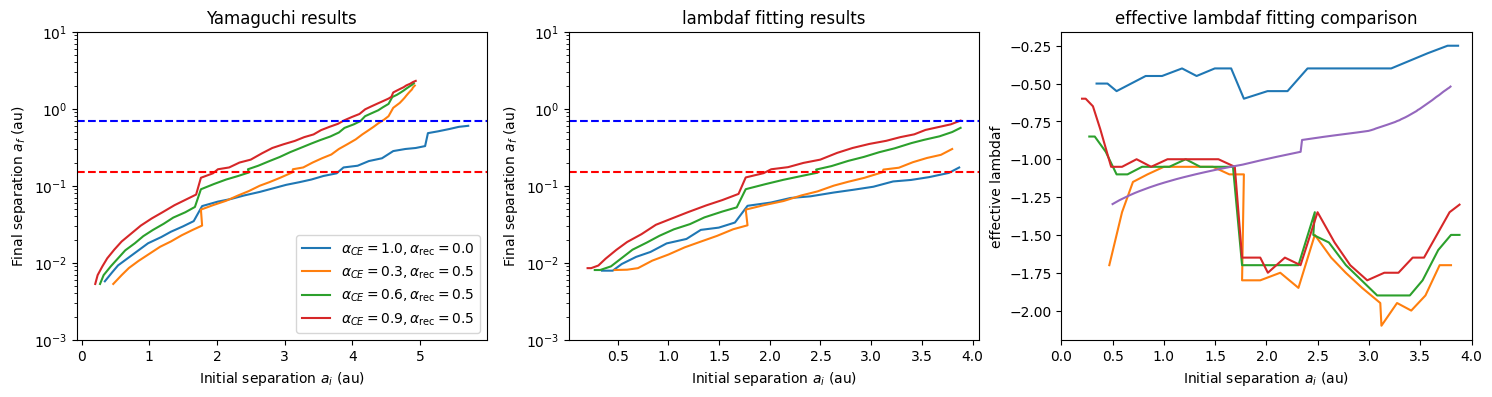

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

for i in range(len(x)):
    x_list = x[i]
    y_list = y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    fitting_x_list = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        if lambdaIndex != -1:
            res.append(data[i][lambdaIndex][indexList[j]])
            lambdaFitting.append(lambdaList[lambdaIndex])
            fitting_x_list.append(x_list[j])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='lower right')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].axhline(y=0.7, color='blue', linestyle='--')
axs[0].set_yscale('log')
axs[0].set_ylim(10**(-3), 10)

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].axhline(y=0.7, color='blue', linestyle='--')
axs[1].set_yscale('log')
axs[1].set_ylim(10**(-3), 10)
print(default_data)
axs[2].plot(ai_list[:-160], default_data[:-160], label = r'$\alpha_{\mathrm{CE}} = 1.0$, Claeys 2014')
axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].set_title('effective lambdaf fitting comparison')
axs[2].set_xlim(0, 4)

# Display the plot
plt.savefig('1.5+0.8 fitting lambdaf comparison whole.png', dpi=300)
plt.show()

i = 0
[-8.649999999999991, -7.1499999999999915, -4.299999999999997, -3.5, -2.8499999999999943, -2.4499999999999886, -1.9499999999999886, -1.5499999999999972, -1.2999999999999972, -1.0, -0.7999999999999972]
i = 1
[-26.099999999999994, -19.75, -15.149999999999991, -9.549999999999997, -7.949999999999989, -6.8999999999999915, -6.349999999999994, -5.6499999999999915, -5.0, -4.199999999999989, -4.0, -3.299999999999997, -2.799999999999997, -2.6499999999999915]
i = 2
[-14.149999999999991, -11.599999999999994, -7.5, -6.75, -5.699999999999989, -5.25, -4.949999999999989, -4.199999999999989, -3.6999999999999886, -3.5, -2.799999999999997, -2.299999999999997, -2.1999999999999886]
i = 3
[-11.099999999999994, -9.149999999999991, -6.1499999999999915, -5.5, -4.949999999999989, -4.5, -4.3999999999999915, -3.8999999999999915, -3.5, -3.0, -3.0, -2.5, -2.0999999999999943, -2.0]


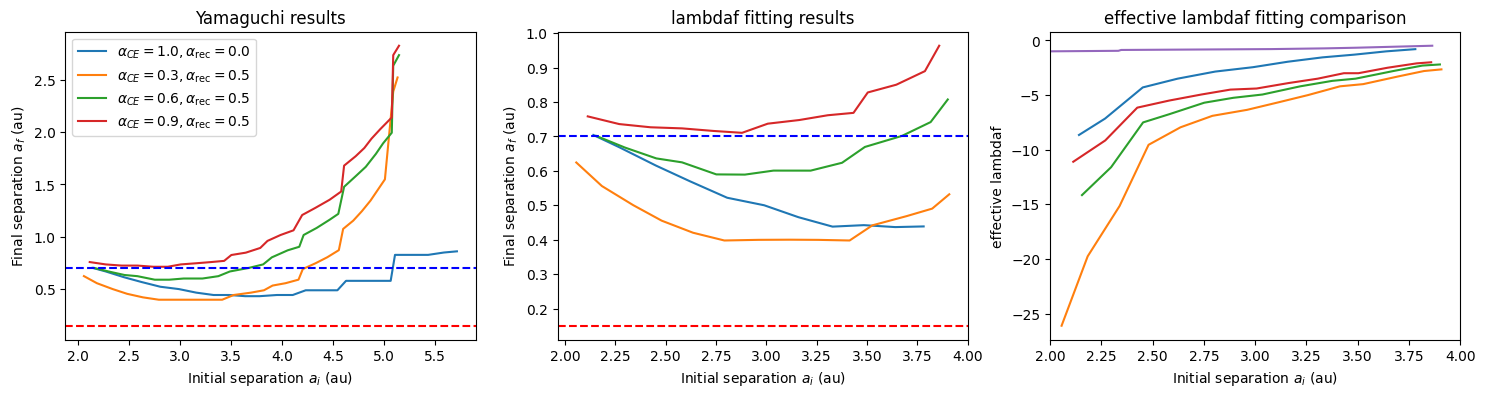

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
data = []
data.append(data1) # data[0] -- alpha = 1
data.append(data4) # data[1] -- alpha = 0.3
data.append(data3) # data[2] -- alpha = 0.6
data.append(data2) # data[3] -- alpha = 0.9

for i in range(len(X)):
    x_list = X[i]
    y_list = Y[i]
    if i == 0: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[0].plot(x_list, y_list, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

for i in range(len(X)):
    x_list = X[i]
    y_list = Y[i]
    indexList = findNearestList(ai_list, x_list)
    res = []
    lambdaFitting = []
    fitting_x_list = []
    for j in range(len(x_list)):
        resultCol = data[i][:, indexList[j]].tolist()
        lambdaIndex = findNearest(resultCol, y_list[j])
        if lambdaIndex != -1:
            res.append(data[i][lambdaIndex][indexList[j]])
            lambdaFitting.append(lambdaList[lambdaIndex])
            fitting_x_list.append(x_list[j])
    print(f'i = {i}')
    print(lambdaFitting)
    if i == 0: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 1.0, \alpha_{\mathrm{rec}} = 0.0$')
    elif i == 1: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.3, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 2: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.6, \alpha_{\mathrm{rec}} = 0.5$')
    elif i == 3: 
        axs[1].plot(fitting_x_list, res, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')
        axs[2].plot(fitting_x_list, lambdaFitting, label = r'$\alpha_{CE} = 0.9, \alpha_{\mathrm{rec}} = 0.5$')

axs[0].set_xlabel('Initial separation $a_i$ (au)')
axs[0].set_ylabel('Final separation $a_f$ (au)')
axs[0].legend(loc='upper left')
axs[0].set_title('Yamaguchi results')
axs[0].axhline(y=0.15, color='red', linestyle='--')
axs[0].axhline(y=0.7, color='blue', linestyle='--')

axs[1].set_xlabel('Initial separation $a_i$ (au)')
axs[1].set_ylabel('Final separation $a_f$ (au)')
axs[1].set_title('lambdaf fitting results')
axs[1].axhline(y=0.15, color='red', linestyle='--')
axs[1].axhline(y=0.7, color='blue', linestyle='--')

axs[2].plot(ai_list[:-155], default_data[:-155], label = r'$\alpha_{\mathrm{CE}} = 1.0$, Claeys 2014')
axs[2].set_xlabel('Initial separation $a_i$ (au)')
axs[2].set_ylabel('effective lambdaf')
axs[2].set_title('effective lambdaf fitting comparison')
axs[2].set_xlim(2, 4)

# Display the plot
plt.savefig('1.5+0.8 fitting lambdaf comparison part.png', dpi=300)
plt.show()